In [169]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import random

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from kaggler.preprocessing import LabelEncoder

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

# 데이터 불러오기

In [170]:
train = pd.read_csv('./open/train.csv')
train = train.drop(['index'], axis=1)

test = pd.read_csv('./open/test.csv')
test = test.drop(['index'], axis=1)

submit = pd.read_csv('./open/sample_submission.csv')

In [171]:
# day를 year로 변경해주는 함수
def days_to_age(x):
    return (x*-1)/365

In [172]:
# 마이너스 변환
def minus(x):
    return x * -1

# 추가 변수 생성하기

In [173]:
def add_var(data):
    
    # 개개인을 구분할 수 있는 변수들을 묶어서 생성
    data['personal_id'] = data['gender'] + "_" + data['DAYS_BIRTH'].apply(str) + "_" + data['income_total'].apply(str) + "_" + data['income_type'].apply(str)
    
    # 카드를 생성한 기간도 같은 경우가 있어서 begin을 추가하여 하나의 변수를 더 생성
    data['personal_begin_id'] = data['gender'] + "_" + data['DAYS_BIRTH'].apply(str) + "_" + data['income_total'].apply(str) + "_" + data['income_type'].apply(str) + "_" + data['begin_month'].apply(str)
    
    # 그외의 변수들을 조합하여 하나의 변수로 추가 생성
    data['g_r_c'] = data['gender'] + "_" + data['reality'] + "_" + data['car'] 
    data['p_w_e_r_c'] = data['phone'].astype(str) + "_" + data['work_phone'].astype(str) + "_" + data['email'].astype(str) + "_" + data['reality'] + "_" + data['car'] 
    
    return data

In [174]:
train = add_var(train)
test = add_var(test)

# 숫자형 변수 전처리 및 변수 생성

다양한 방법으로 전처리 및 변수 생성을 진행하면서 성능이 제일 잘 나온 경우로 정리하였습니다.

In [175]:
def numeric_process(data):
    
    # income_total 변수 전처리
    # 만단위로 생성
    data['income_total'] = data['income_total']/10000
    # 편차 제곱 변수 생성
    data['income_total_dev'] = (data['income_total'] - data['income_total'].mean())**2
    # 로그 변환
    data['income_total_log'] = data['income_total'].apply(np.log)

    # DAYS_EMPLOYED 변수 전처리
    # 로그 변환
    data['DAYS_EMPLOYED_log'] = data['DAYS_EMPLOYED'].map(lambda x: x if x < 0 else 0).apply(lambda x: np.log1p(x*-1))
    # day를 year로 변환
    data.loc[train['DAYS_EMPLOYED'] >= 0,'DAYS_EMPLOYED']=0
    data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].apply(days_to_age)
    
    # begin_month 변수 전처리
    # 마이너스 변환
    data['begin_month'] = data['begin_month'].apply(minus)
    
    # DAYS_BIRTH 변수 전처리
    # day를 year로 변환
    data['DAYS_BIRTH'] = data['DAYS_BIRTH'].apply(days_to_age)
    
    #  DAYS_BIRTH, DAYS_EMPLOYED 비율로 income 데이터 전처리
    data['EMPLOYED_BIRTH_RATIO'] = data['DAYS_EMPLOYED']/data['DAYS_BIRTH']
    data['INCOME_EMPLOYED_RATIO'] = data['income_total']/data['DAYS_EMPLOYED']
    data['INCOME_BIRTH_RATIO'] = data['income_total']/data['DAYS_BIRTH']
    
    # chid_num과 family_size는 다음과 같이 최대 2와 5가 되도록 전처리
    data['diff_fam_child'] = data['family_size'] - data['child_num']
    data.loc[data['child_num'] >= 2,'child_num'] = 2
    data.loc[data['family_size'] >= 5,'child_num'] = 5
    
    # 가족수와 자녀수 sum
    data['FAM_CHILD_SUM'] = data[['child_num', 'family_size']].sum(axis=1)
    
    # income을 가족 수로 나눈 비율
    data['INCOME_FAM_SUM_RATIO'] = data['income_total']/data['family_size']
    
    # 일을하게 된 시점 변수 추가
    data['before_EMPLOYED'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
    data['INCOME_before_EMPLOYED_RATIO'] = data['income_total']/data['before_EMPLOYED']
    
    return data 

In [176]:
train = numeric_process(train)
test = numeric_process(test)

In [177]:
def occype_process(data):
    
    # 경력이 없고 직업군이 none인 사람은 no_work로 대체
    data['occyp_type'] = data['occyp_type'].fillna('NAN')
    #data.loc[(data['DAYS_EMPLOYED'] == 0) & (data['occyp_type'] == 'NAN'), 'occyp_type'] = 'no_work'
    
    return data


In [178]:
train = occype_process(train)
test = occype_process(test)

In [179]:
#minus 변경하고
#구간화 함수
def make_bin(df, variable, n):
    
    data = df
    #data[variable] =- data[variable]
    count, bin_dividers = np.histogram(data[variable], bins=n)
    bin_names=[str(i) for i in range(n)]
    data['%s_bin' % variable]=pd.cut(x=data[variable], bins=bin_dividers, labels=bin_names, include_lowest=True)
    data['%s_bin' % variable] = pd.factorize(data['%s_bin' % variable])[0]

In [180]:
# days_birth만 구간화 했을 떄 가장 성능이 좋았음

make_bin(train, 'DAYS_BIRTH', n=10)
# make_bin(train, 'income_total_log', n=25)
# make_bin(train, 'DAYS_EMPLOYED_log', n=15)
#make_bin(train, 'begin_month', n=6)
make_bin(test, 'DAYS_BIRTH', n=10)
# make_bin(test, 'income_total_log', n=25)
# make_bin(test, 'DAYS_EMPLOYED_log', n=15)
#make_bin(test, 'begin_month', n=6)

In [181]:
def remove_outlier(train, column):
    
    df = train[column]
    # 1분위수
    quan_25 = np.percentile(df.values, 25)
    
    # 3분위수
    quan_75 = np.percentile(df.values, 75)
    
    iqr = quan_75 - quan_25
    
    lowest = quan_25 - iqr * 5
    highest = quan_75 + iqr * 5
    outlier_index = df[(df < lowest) | (df > highest)].index
    print('outlier의 수 : ' , len(outlier_index))
    train.drop(outlier_index, axis = 0, inplace = True)
    
    return train


In [182]:
# candidate = ['income_total', 'DAYS_EMPLOYED']
# for cand in candidate:  
#     train = remove_outlier(train,cand)

# train.reset_index(drop = True,inplace = True)
# len(train)

In [183]:
# 불필요 변수 제거
train = train.drop(['income_total', 'DAYS_EMPLOYED', 'FLAG_MOBIL'], axis=1)
test = test.drop(['income_total', 'DAYS_EMPLOYED', 'FLAG_MOBIL'], axis=1)

In [184]:
train.shape, test.shape

((26457, 32), (10000, 31))

In [185]:
train_x = train.drop(['credit'],axis=1)
train_y = train['credit']

In [186]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        26457 non-null  object 
 1   car                           26457 non-null  object 
 2   reality                       26457 non-null  object 
 3   child_num                     26457 non-null  int64  
 4   income_type                   26457 non-null  object 
 5   edu_type                      26457 non-null  object 
 6   family_type                   26457 non-null  object 
 7   house_type                    26457 non-null  object 
 8   DAYS_BIRTH                    26457 non-null  float64
 9   work_phone                    26457 non-null  int64  
 10  phone                         26457 non-null  int64  
 11  email                         26457 non-null  int64  
 12  occyp_type                    26457 non-null  object 
 13  f

# 모델 학습

In [187]:
cat_models={}

# object형 변수는 cat_features에 추가
cat_features = [0,1,2,4,5,6,7,12,15,16,17,18]
random_seed = [1042]

def run_kfold():
    
    folds=StratifiedKFold(n_splits=10, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test.shape[0], 3))  
    
    for seed in random_seed:
        for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
            print(f'===================================={n_fold+1}============================================')
            
            X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
            y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]

            # early_stopping 50에서 가장 좋은 점수를 내는 learning_rate를 활용
            cat = CatBoostClassifier(n_estimators=3000, max_depth=8, random_seed=seed, learning_rate =0.04, bootstrap_type ='Bernoulli')
            cat.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_val, y_val)],
                  early_stopping_rounds=50, cat_features=cat_features,
                  verbose=100)

            cat_models[n_fold] = cat

            predictions = cat.predict_proba(X_val)
            test_predictions = cat.predict_proba(test)

            logloss=log_loss(to_categorical(y_val), predictions)
            outcomes.append(logloss)
            print(f"FOLD {n_fold+1} : logloss:{logloss}")

            sub+= test_predictions

            print(f'================================================================================\n\n')

    mean_outcome=np.mean(outcomes)
    print("Mean:{}".format(mean_outcome))
    return sub/(folds.n_splits * len(random_seed))
    
my_submission = run_kfold()

====================================1============================================
0:	learn: 1.0754286	test: 1.0754143	test1: 1.0757611	best: 1.0757611 (0)	total: 120ms	remaining: 5m 59s
100:	learn: 0.7167939	test: 0.5155491	test1: 0.6916850	best: 0.6916850 (100)	total: 11.7s	remaining: 5m 37s
200:	learn: 0.7006608	test: 0.4890761	test1: 0.6847435	best: 0.6847402 (199)	total: 25.4s	remaining: 5m 53s
300:	learn: 0.6855585	test: 0.4719182	test1: 0.6825039	best: 0.6825022 (299)	total: 40.4s	remaining: 6m 1s
400:	learn: 0.6713284	test: 0.4645902	test1: 0.6811186	best: 0.6810843 (397)	total: 55.6s	remaining: 6m
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6806116747
bestIteration = 443

Shrink model to first 444 iterations.
FOLD 1 : logloss:0.6806116746606794


====================================2============================================
0:	learn: 1.0754597	test: 1.0754597	test1: 1.0754409	best: 1.0754409 (0)	total: 77.6ms	remaining: 3m 52s
100:	learn: 0.7168537	te

0:	learn: 1.0753016	test: 1.0752726	test1: 1.0751379	best: 1.0751379 (0)	total: 176ms	remaining: 8m 48s
100:	learn: 0.7167503	test: 0.5137462	test1: 0.6695160	best: 0.6695160 (100)	total: 14.4s	remaining: 6m 53s
200:	learn: 0.6996049	test: 0.4899406	test1: 0.6628576	best: 0.6628576 (200)	total: 32.7s	remaining: 7m 35s
300:	learn: 0.6847015	test: 0.4815721	test1: 0.6607244	best: 0.6606921 (299)	total: 51.7s	remaining: 7m 43s
400:	learn: 0.6690549	test: 0.4768017	test1: 0.6597974	best: 0.6597974 (400)	total: 1m 11s	remaining: 7m 42s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6597974237
bestIteration = 400

Shrink model to first 401 iterations.
FOLD 10 : logloss:0.6597974236686501


Mean:0.6668083902245281


# Feature_Importance_Plot

In [188]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')


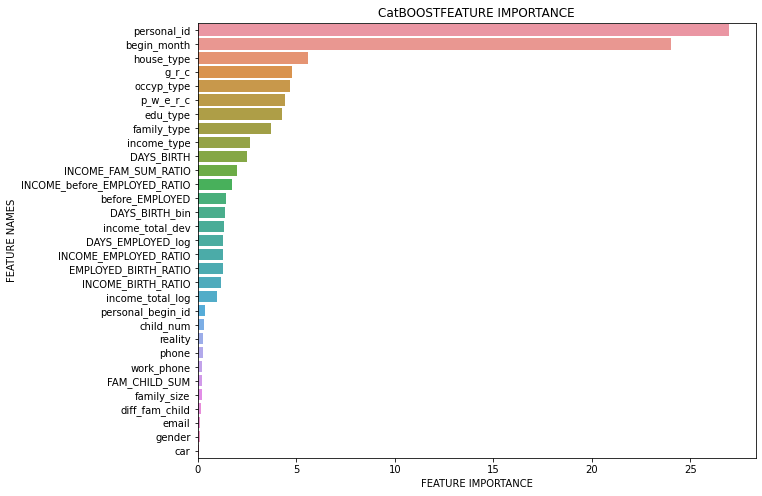

In [189]:
#plot the xgboost result
plot_feature_importance(cat_models[0].get_feature_importance(), train_x.columns,'CatBOOST')

# 결과 확인 및 제출 파일 생성

In [190]:
my_submission

array([[0.12346708, 0.16851871, 0.70801421],
       [0.33358888, 0.23703332, 0.42937779],
       [0.04621756, 0.0760359 , 0.87774654],
       ...,
       [0.04879712, 0.12312376, 0.82807912],
       [0.14931604, 0.313766  , 0.53691795],
       [0.06779281, 0.43125984, 0.50094735]])

In [191]:
submission=pd.read_csv('./open/sample_submission.csv')
submission.loc[:,1:]=my_submission
submission

,index,0,1,2
0,26457,0.123467,0.168519,0.708014
1,26458,0.333589,0.237033,0.429378
2,26459,0.046218,0.076036,0.877747
3,26460,0.067901,0.089168,0.842931
4,26461,0.077621,0.232309,0.690070
...,...,...,...,...
9995,36452,0.073980,0.231278,0.694742
9996,36453,0.149508,0.389064,0.461428
9997,36454,0.048797,0.123124,0.828079
9998,36455,0.149316,0.313766,0.536918


In [192]:
submission.to_csv('./submit/10fold_cat_0.6668.csv', index=False) # 0.7272812144

In [193]:
submission.head(20)

,index,0,1,2
0,26457,0.123467,0.168519,0.708014
1,26458,0.333589,0.237033,0.429378
2,26459,0.046218,0.076036,0.877747
3,26460,0.067901,0.089168,0.842931
4,26461,0.077621,0.232309,0.690070
5,26462,0.059032,0.136851,0.804116
6,26463,0.603607,0.366428,0.029965
7,26464,0.051798,0.087963,0.860239
8,26465,0.065611,0.094430,0.839959
9,26466,0.054871,0.277506,0.667623
